In [4]:
import os
import collections
import json
import torch
import numpy as np

import matplotlib.pyplot as plt
import glob

import PIL
from PIL import Image
from tqdm.notebook import tqdm
from torch.utils import data
from torchvision import transforms

In [5]:
from datasets.VOC2012 import VOC2012_Dataset
from model.bisenet_v2 import BiSeNetV2

In [6]:
# Init Network, Loss and Optimizer
net = BiSeNetV2(n_classes=21)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

Loaded pretrained weights for efficientnet-b0


In [7]:
# Init Training Data Loader
train_data = VOC2012_Dataset(
    root="G:/Codes/RealTime-Segementation/datasets/VOC2012", 
    img_size=(256, 256)
)
batch_size = 16
train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=False)

In [8]:
# Trial Run for Training
n_epochs = 10
n_steps = 1
pbar = tqdm(total=n_steps*n_epochs)
for epoch in range(n_epochs):
    for i, (img, label) in enumerate(train_dataloader):
        y_pred = net(img)
        loss = criterion(y_pred, label)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.update()
        pbar.set_postfix({'train_loss': f'{loss:.4f}'})
        if i+1 >= n_steps:
            break
pbar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

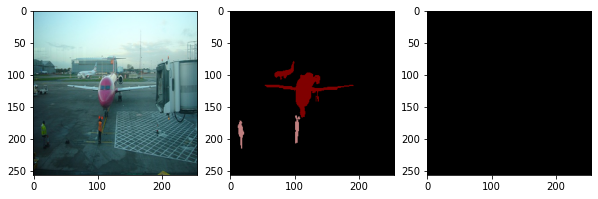

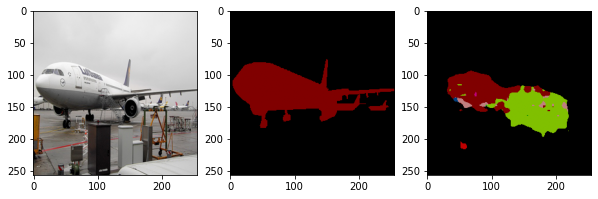

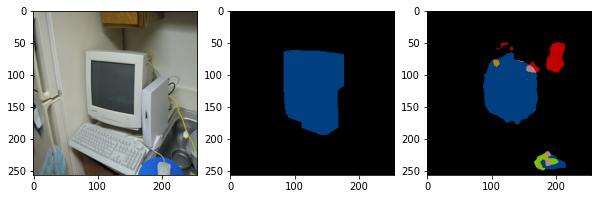

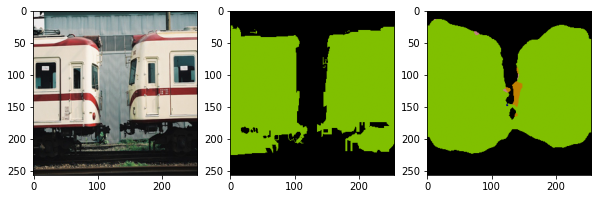

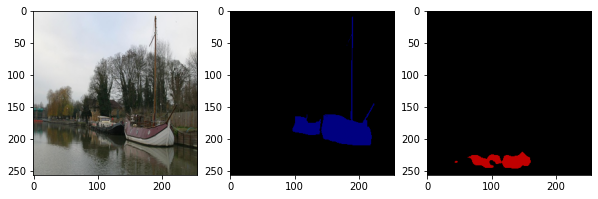

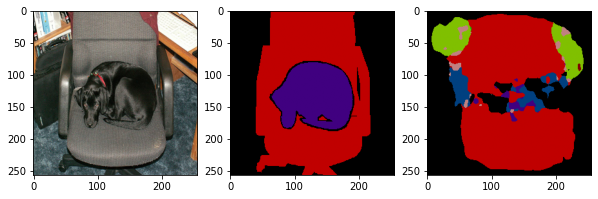

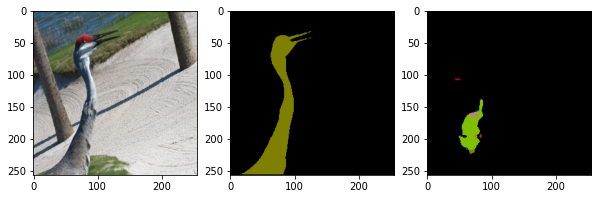

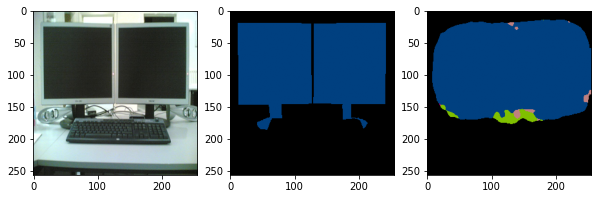

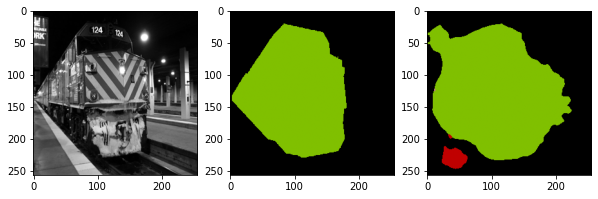

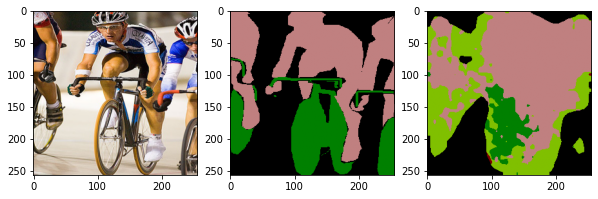

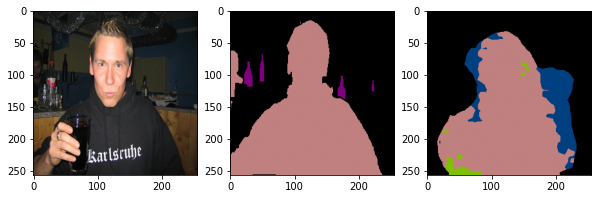

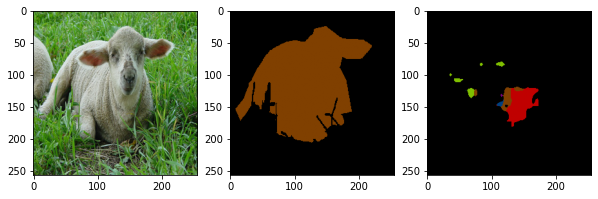

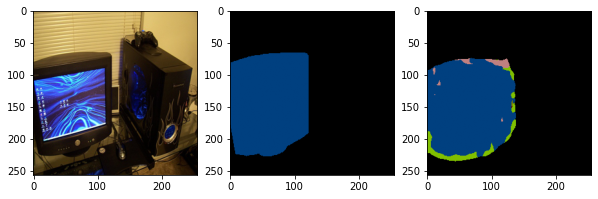

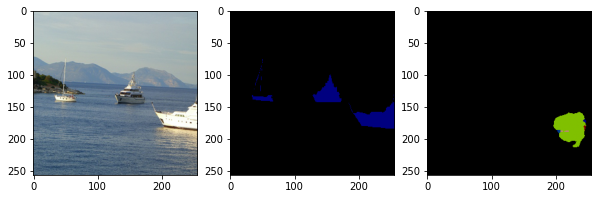

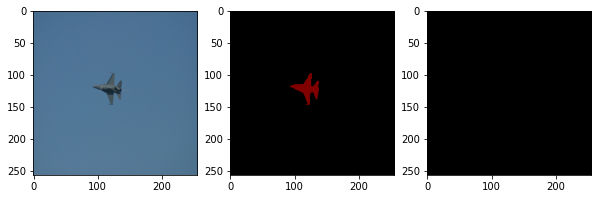

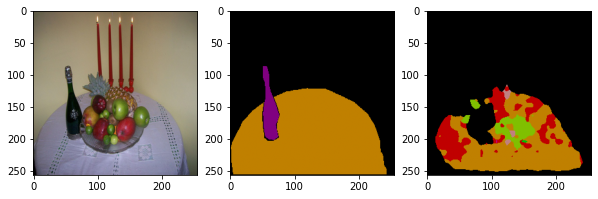

In [7]:
# Inference
for i, (inputs, labels) in enumerate(train_dataloader):
    outs = net(inputs)
    break
for k in range(16):
    img = VOC2012_Dataset.denormalize(inputs[k]).numpy().transpose([1,2,0])
    label = VOC2012_Dataset.decode_segmap(labels.numpy()[k])
    preds = torch.argmax(outs, dim=1)
    pred = VOC2012_Dataset.decode_segmap(preds.numpy()[k]) 
    plt.figure(figsize=(10,10))
    plt.subplot(131), plt.imshow(img)
    plt.subplot(132), plt.imshow(label)
    plt.subplot(133), plt.imshow(pred)
    plt.show()